# Exploring Dandiset 001433: Breathing rhythm and place dataset

**Important:** This notebook was AI-generated and has not been fully verified. Please exercise caution when interpreting the code or results.

## Overview of the Dandiset

This Dandiset, DANDI:001433 version 0.250507.2356, contains behavioral and electrophysiological data from recordings of sniffing, video, and olfactory bulb electrophysiology in freely-behaving mice. The mice were not given any stimulus, reward, or task. The data were collected as part of research into the relationship between breathing rhythm and neural activity in the olfactory bulb.

You can access the Dandiset here: [https://dandiarchive.org/dandiset/001433/0.250507.2356](https://dandiarchive.org/dandiset/001433/0.250507.2356)

## What this notebook covers

This notebook will demonstrate how to:
- Load the Dandiset using the DANDI API.
- Load a specific NWB file from the Dandiset.
- Examine the contents and metadata of the NWB file.
- Visualize a subset of the LFP and Sniff Signal data.
- Visualize detected exhalation and inhalation event times.
- Calculate basic statistics for selected data subsets.

## Required packages

This notebook requires the following packages:
- `dandi`
- `pynwb`
- `h5py`
- `remfile`
- `matplotlib`
- `numpy`
- `pandas`
- `seaborn`

## Loading the Dandiset

We will use the `dandi` package to connect to the DANDI archive and access the Dandiset.

In [1]:
from itertools import islice
from dandi.dandiapi import DandiAPIClient

# Connect to DANDI archive
client = DandiAPIClient()
dandiset = client.get_dandiset("001433", "0.250507.2356")

# Print basic information about the Dandiset
metadata = dandiset.get_raw_metadata()
print(f"Dandiset name: {metadata['name']}")
print(f"Dandiset URL: {metadata['url']}")

# List some assets in the Dandiset to see available files
assets = dandiset.get_assets()
print("\nFirst 5 assets:")
for asset in islice(assets, 5):
    print(f"- {asset.path} (ID: {asset.identifier})")

# Note: You can use client.get_asset(<asset_id>) to get more details about a specific asset, including its size.

Dandiset name: Breathing rhythm and place dataset
Dandiset URL: https://dandiarchive.org/dandiset/001433/0.250507.2356

First 5 assets:
- sub-4122/sub-4122_ses-20250507T152927_ecephys.nwb (ID: 63d19f03-2a35-48bd-a54f-9ab98ceb7be2)
- sub-4122/sub-4122_ses-20250507T152930_ecephys.nwb (ID: cce2f86c-2440-4358-8298-75cb2faa83f1)
- sub-4122/sub-4122_ses-20250507T152933_ecephys.nwb (ID: 154a5db2-9bad-48b9-bbe4-13376c315cbe)
- sub-4127/sub-4127_ses-20250507T152941_ecephys.nwb (ID: 8a2c176c-846d-432c-9c7b-cfd0cefa40cb)
- sub-4127/sub-4127_ses-20250507T152953_ecephys.nwb (ID: ba3b58b3-38ff-49d4-bc73-2105c87ecf49)


## Loading an NWB file

We will now load one of the NWB files from the Dandiset using `pynwb`. We will load data from the file located at:
`sub-4122/sub-4122_ses-20250507T152927_ecephys.nwb`

This file has the asset ID `63d19f03-2a35-48bd-a54f-9ab98ceb7be2`.

The data in this NWB file includes electrophysiology (LFP) and sniff signals from a mouse.

In [2]:
import pynwb
import h5py
import remfile

# Define the URL for the selected NWB asset
nwb_url = "https://api.dandiarchive.org/api/assets/63d19f03-2a35-48bd-a54f-9ab98ceb7be2/download/"

# Load the NWB file contents
# We use remfile and h5py to enable streaming data directly from the web.
remote_file = remfile.File(nwb_url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file)
nwb = io.read()

# Display some basic metadata from the NWB file
print(f"NWB file identifier: {nwb.identifier}")
print(f"Session description: {nwb.session_description}")
print(f"Session start time: {nwb.session_start_time}")
print(f"Experimenter: {nwb.experimenter}")
print(f"Subject ID: {nwb.subject.subject_id}")
print(f"Subject species: {nwb.subject.species}")
print(f"Subject age: {nwb.subject.age} ({nwb.subject.age__reference} reference)")


# Note: Printing the entire nwb object is not recommended due to potentially large output.

NWB file identifier: 4122_4
Session description: LFP and sniff recording
Session start time: 2025-05-07 15:29:27.359523-07:00
Experimenter: ('Rafilson, Sidney',)
Subject ID: 4122
Subject species: Mus musculus
Subject age: P90D (birth reference)


/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.8.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


## Exploring the NWB file contents

This NWB file contains several types of data. Here's a summary of the main data interfaces available within the file. The data streams in `acquisition` represent the raw recorded signals, while data streams in `processing['behavior']` are derived or analyzed from the raw data.

**Acquisition:**
- `LFP` (ElectricalSeries): Local Field Potential signal from the olfactory bulb. Measured in volts.
- `SniffSignal` (TimeSeries): Raw sniff thermistor voltage, reflecting changes in air flow during breathing. Measured in volts.

**Processing (behavior):**
- `exhalation_time` (TimeSeries): Timestamps in seconds corresponding to detected exhalation events.
- `inhalation_time` (TimeSeries): Timestamps in seconds corresponding to detected inhalation events.

**Electrodes:**
The file also includes metadata about the recording electrodes used for the LFP signal:

| Column Name | Description |
|-------------|-------------|
| location    | Location of channel within the subject (e.g., brain region). For these data, it is 'Olfactory Bulb'. |
| group       | Reference to the ElectrodeGroup which defines properties shared by a group of electrodes. |
| group_name  | The name of the ElectrodeGroup (e.g., 'LFPGroup'). |
| filtering   | Description of hardware filtering applied to the signal, including the filter name and frequency cutoffs. |

You can view the electrode metadata as a pandas DataFrame:

In [3]:
import pandas as pd

# View electrode metadata
electrodes_df = nwb.electrodes.to_dataframe()
print("Electrode Metadata:")
print(electrodes_df.head())

Electrode Metadata:
          location                                              group  \
id                                                                      
0   olfactory bulb  LFPGroup pynwb.ecephys.ElectrodeGroup at 0x129...   
1   olfactory bulb  LFPGroup pynwb.ecephys.ElectrodeGroup at 0x129...   
2   olfactory bulb  LFPGroup pynwb.ecephys.ElectrodeGroup at 0x129...   
3   olfactory bulb  LFPGroup pynwb.ecephys.ElectrodeGroup at 0x129...   
4   olfactory bulb  LFPGroup pynwb.ecephys.ElectrodeGroup at 0x129...   

   group_name filtering  
id                       
0    LFPGroup      none  
1    LFPGroup      none  
2    LFPGroup      none  
3    LFPGroup      none  
4    LFPGroup      none  


## Visualizing LFP and Sniff Signal data

We will now visualize a small subset of the LFP and Sniff Signal data to illustrate how to access and plot this data. We will plot the first 10 seconds of data from the first LFP channel and the Sniff Signal. The units for both signals are in volts.

LFP subset (first channel, 0-10s): Mean = -54.89 volts, Std Dev = 759.94 volts
Sniff Signal subset (0-10s): Mean = -1021.98 volts, Std Dev = 3476.87 volts


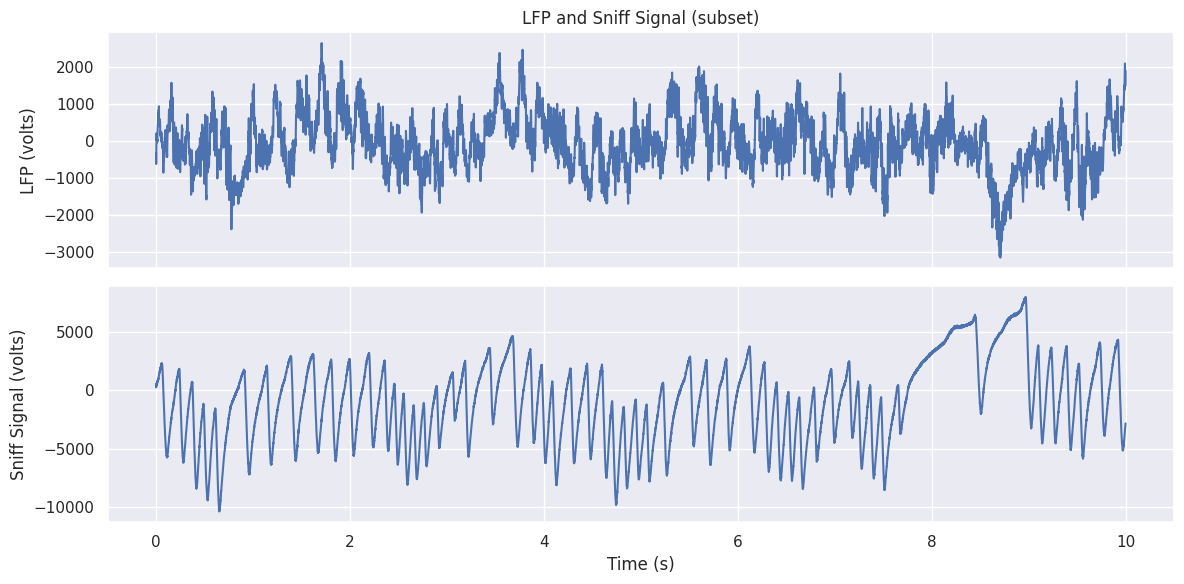

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set a seaborn theme for better aesthetics (optional)
sns.set_theme()

# Get the LFP and SniffSignal TimeSeries objects
lfp_ts = nwb.acquisition["LFP"]
sniff_ts = nwb.acquisition["SniffSignal"]

# Define the time window to load (e.g., first 10 seconds)
start_time = 0
end_time = 10
sampling_rate = lfp_ts.rate # Assuming both LFP and SniffSignal have the same sampling rate
start_index = int(start_time * sampling_rate)
end_index = int(end_time * sampling_rate)

# Load a subset of the data
# Note: We are loading only a small subset to avoid excessive memory usage and network transfer.
lfp_subset_data = lfp_ts.data[start_index:end_index, 0] # Load data from the first LFP channel (index 0)
sniff_subset_data = sniff_ts.data[start_index:end_index]

# Create a time vector for the subset
time_vector = np.arange(start_index, end_index) / sampling_rate

# Calculate basic statistics for the subsets
lfp_mean = np.mean(lfp_subset_data)
lfp_std = np.std(lfp_subset_data)
sniff_mean = np.mean(sniff_subset_data)
sniff_std = np.std(sniff_subset_data)

print(f"LFP subset (first channel, {start_time}-{end_time}s): Mean = {lfp_mean:.2f} {lfp_ts.unit}, Std Dev = {lfp_std:.2f} {lfp_ts.unit}")
print(f"Sniff Signal subset ({start_time}-{end_time}s): Mean = {sniff_mean:.2f} {sniff_ts.unit}, Std Dev = {sniff_std:.2f} {sniff_ts.unit}")


# Create plots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 6))

ax1.plot(time_vector, lfp_subset_data)
ax1.set_ylabel(f'LFP ({lfp_ts.unit})')
ax1.set_title('LFP and Sniff Signal (subset)')

ax2.plot(time_vector, sniff_subset_data)
ax2.set_ylabel(f'Sniff Signal ({sniff_ts.unit})')
ax2.set_xlabel('Time (s)')

plt.tight_layout()
plt.show()

## Exploring Exhalation and Inhalation Times

The NWB file also contains processed data related to sniffing behavior, specifically the timestamps of exhalation and inhalation events. Let's examine these timestamps.

In [5]:
# Get the exhalation and inhalation TimeSeries objects
exhalation_ts = nwb.processing["behavior"]["exhalation_time"]
inhalation_ts = nwb.processing["behavior"]["inhalation_time"]

# Load the timestamps (these are relatively small datasets)
exhalation_times = exhalation_ts.timestamps[:]
inhalation_times = inhalation_ts.timestamps[:]

print(f"Number of exhalation events: {len(exhalation_times)}")
print(f"First 10 exhalation times (s): {exhalation_times[:10]}")

print(f"\nNumber of inhalation events: {len(inhalation_times)}")
print(f"First 10 inhalation times (s): {inhalation_times[:10]}")

Number of exhalation events: 10030
First 10 exhalation times (s): [ 115.  283.  418.  534.  653.  961. 1188. 1444. 1672. 1855.]

Number of inhalation events: 10030
First 10 inhalation times (s): [  58.  241.  373.  490.  612.  907. 1144. 1391. 1618. 1807.]


### Visualizing Exhalation and Inhalation Times

We can visualize these timestamps as markers to show their timing. To provide context, we will plot a subset of the sniff signal alongside the timestamps within the same 10-second window we used previously. We will use separate y-axes for clarity to ensure the timestamp markers are clearly visible relative to the sniff signal.

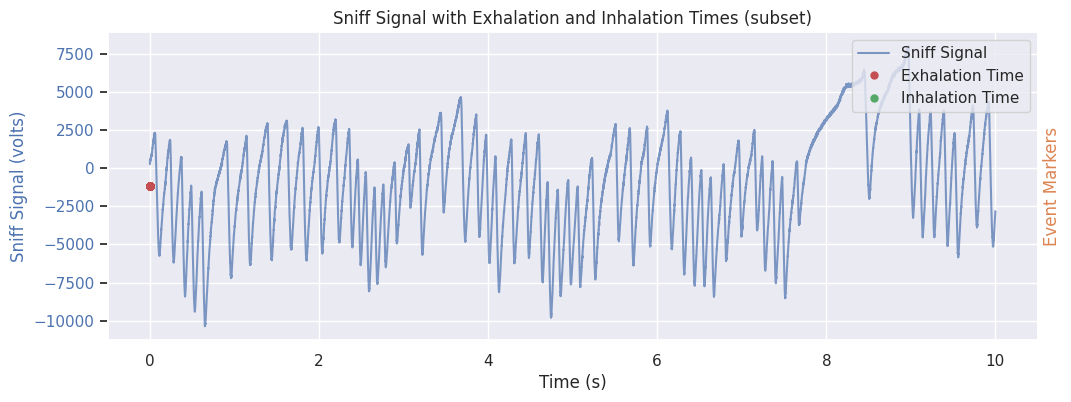

In [6]:
# Filter exhalation and inhalation times within the plotted time window
exhalation_times_subset = exhalation_times[(exhalation_times >= start_time) & (exhalation_times <= end_time)]
inhalation_times_subset = inhalation_times[(inhalation_times >= start_time) & (inhalation_times <= end_time)]

# Create plot with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 4))

# Plot sniff signal subset on the first y-axis
ax1.plot(time_vector, sniff_subset_data, label='Sniff Signal', alpha=0.7, color='C0')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel(f'Sniff Signal ({sniff_ts.unit})', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')

# Create a second y-axis for the timestamp markers
ax2 = ax1.twinx()
ax2.plot(exhalation_times_subset, np.ones_like(exhalation_times_subset) * 0.1, 'ro', label='Exhalation Time', markersize=5)
ax2.plot(inhalation_times_subset, np.ones_like(inhalation_times_subset) * -0.1, 'go', label='Inhalation Time', markersize=5)
ax2.set_ylabel('Event Markers', color='C1')
ax2.tick_params(axis='y', labelcolor='C1')
ax2.set_yticks([]) # Hide y-axis ticks for markers

ax1.set_title('Sniff Signal with Exhalation and Inhalation Times (subset)')
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.grid(True)
plt.show()

## Summary and Future Directions

This notebook provided a basic introduction to accessing and exploring the data within Dandiset 001433, focusing on one NWB file. We demonstrated how to load the Dandiset and an NWB file, examine its structure and metadata, calculate basic statistics for data subsets, and visualize subsets of the LFP and Sniff Signal data, along with the detected exhalation and inhalation times.

This is just a starting point. The Dandiset contains more NWB files, potentially with other types of data such as video, that could be explored. Furthermore, the size of the data streams can be significant, so be mindful of memory and network limitations when loading larger portions of the data.

Possible future directions for analysis include:
- Analyzing more extensive portions of the LFP and Sniff Signal data.
- Investigating the precise relationship between LFP activity and sniffing behavior, potentially by aligning LFP data to sniff cycles defined by the inhalation and exhalation times.
- Exploring other data streams or processing modules present in other NWB files within the Dandiset, such as video data.
- Performing spectral analysis on the LFP data to examine oscillatory activity.
- Utilizing the exhalation and inhalation timestamps to segment or align other data for trial-based analysis.

In [7]:
# Close the NWB file
io.close()